<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-prepare-data" data-toc-modified-id="Load-and-prepare-data-1">Load and prepare data</a></span><ul class="toc-item"><li><span><a href="#Schools" data-toc-modified-id="Schools-1.1">Schools</a></span></li><li><span><a href="#Routes" data-toc-modified-id="Routes-1.2">Routes</a></span><ul class="toc-item"><li><span><a href="#Add-treatment-indicator-from-schools" data-toc-modified-id="Add-treatment-indicator-from-schools-1.2.1">Add treatment indicator from schools</a></span></li></ul></li><li><span><a href="#Monthly-crime-rates" data-toc-modified-id="Monthly-crime-rates-1.3">Monthly crime rates</a></span><ul class="toc-item"><li><span><a href="#Only-blocks-which-are-in-at-least-one-year-treated-or-one,-two,-or-three-cells-over" data-toc-modified-id="Only-blocks-which-are-in-at-least-one-year-treated-or-one,-two,-or-three-cells-over-1.3.1">Only blocks which are in at least one year treated or one, two, or three cells over</a></span></li></ul></li><li><span><a href="#Blocks-with-running-variable-for-Figure-3" data-toc-modified-id="Blocks-with-running-variable-for-Figure-3-1.4">Blocks with running variable for Figure 3</a></span><ul class="toc-item"><li><span><a href="#Aggregate" data-toc-modified-id="Aggregate-1.4.1">Aggregate</a></span></li></ul></li><li><span><a href="#Yearly-crime-counts" data-toc-modified-id="Yearly-crime-counts-1.5">Yearly crime counts</a></span></li></ul></li><li><span><a href="#Analysis-of-estimation-dataset" data-toc-modified-id="Analysis-of-estimation-dataset-2">Analysis of estimation dataset</a></span></li><li><span><a href="#Replication-of-descriptives" data-toc-modified-id="Replication-of-descriptives-3">Replication of descriptives</a></span><ul class="toc-item"><li><span><a href="#Figure-A.2" data-toc-modified-id="Figure-A.2-3.1">Figure A.2</a></span></li><li><span><a href="#Table-1" data-toc-modified-id="Table-1-3.2">Table 1</a></span></li><li><span><a href="#Table-2" data-toc-modified-id="Table-2-3.3">Table 2</a></span></li><li><span><a href="#Figure-3" data-toc-modified-id="Figure-3-3.4">Figure 3</a></span></li></ul></li><li><span><a href="#Replication-of-main-results" data-toc-modified-id="Replication-of-main-results-4">Replication of main results</a></span><ul class="toc-item"><li><span><a href="#Table-10-(column-3-and-7)" data-toc-modified-id="Table-10-(column-3-and-7)-4.1">Table 10 (column 3 and 7)</a></span><ul class="toc-item"><li><span><a href="#Empirical-Strategy" data-toc-modified-id="Empirical-Strategy-4.1.1">Empirical Strategy</a></span></li><li><span><a href="#Estimation" data-toc-modified-id="Estimation-4.1.2">Estimation</a></span></li></ul></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-5">Results</a></span></li></ul></div>

**Description**: Replicate census block results (crime) for [Mc Millen et al. (2017)](https://ignaciomsarmiento.github.io/assets/Safe_Passage_WP.pdf) as well as some descriptive statistics.

In [1]:
import pickle
import sys
from pathlib import Path

import altair as alt
import geopandas as gpd
import pandas as pd
import numpy as np
import ipywidgets as widgets
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

sys.path.append('../..')
from src.analysis.figures import format_chart, save_to_jekyll

In [2]:
# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Set path to data folder

In [3]:
project_folder = Path('../..')
data_path = project_folder / 'data'

# Load and prepare data

## Schools

In [4]:
with (data_path / 'processed/schools_blocks.pkl').open('rb') as f:
    schools = pickle.load(f)
schools['treated'] = schools['treated_foia']
schools = schools.drop('treated_foia', axis='columns')

## Routes

In [5]:
with (data_path / 'processed/routes.pkl').open('rb') as f:
    routes = pickle.load(f)

### Add treatment indicator from schools

Add earlier school years

In [6]:
school_years = ['SY0910', 'SY1011', 'SY1112', 'SY1213']
earlier_routes = []
routes_1314 = routes.query('school_year == "SY1314"')
for sy in school_years:
    temp_routes = routes_1314.copy()
    temp_routes['school_year'] = sy
    earlier_routes.append(temp_routes)

routes = pd.concat([routes] + earlier_routes, ignore_index=True)

In [7]:
assert not routes.duplicated(subset=['school_year', 'route_number']).any()

In [8]:
routes = routes.merge(
    schools[['school_name', 'school_year', 'treated']],
    how='left',
    on=['school_name', 'school_year'], validate='m:1')

## Monthly crime rates

### Only blocks which are in at least one year treated or one, two, or three cells over

In [10]:
with (data_path / 'processed/est_df.pkl').open('rb') as f:
    est_df = pickle.load(f)
est_df.head()

,tract_bloc,school_year,Date,violent_count,property_count,route_number,school_name,treated,one_over,two_over,three_over,info,tb_sy,time_fe
0,208011000.0,SY0506,2006-01-31,0.0,0.0,NaN,NaN,0.0,0,0,0,-,208011000.0SY0506,200601
1,208011000.0,SY0506,2006-02-28,0.0,0.0,NaN,NaN,0.0,0,0,0,-,208011000.0SY0506,200602
2,208011000.0,SY0506,2006-03-31,0.0,0.0,NaN,NaN,0.0,0,0,0,-,208011000.0SY0506,200603
3,208011000.0,SY0506,2006-04-30,0.0,0.0,NaN,NaN,0.0,0,0,0,-,208011000.0SY0506,200604
4,208011000.0,SY0506,2006-05-31,0.0,1.0,NaN,NaN,0.0,0,0,0,-,208011000.0SY0506,200605


According to Table 10 in McMillen et al. (2017), they had a sample size of 783,340 for the main specification. It is unclear, why I got more than double the observations.

In [11]:
est_df['school_year'].unique()

array(['SY0506', 'SY0607', 'SY0708', 'SY0809', 'SY0910', 'SY1011',
       'SY1112', 'SY1213', 'SY1314', 'SY1415', 'SY1516'], dtype=object)

## Blocks with running variable for Figure 3

In [12]:
with (data_path / 'processed/figures/blocks_fig_3.pkl').open('rb') as f:
    blocks_fig_3 = pickle.load(f)

### Aggregate

In [13]:
blocks_fig_3.head()

,tract_bloc,school_year,violent_count,property_count,treated,one_over,two_over,three_over,info,run_var_treated,run_var_one,run_var_two,run_var_three,run_var,block_status
3,208011000.0,SY0809,0.0,0.0,0.0,0,0,0,-,NaN,NaN,NaN,-5.0,-5.0,Three over
4,208011000.0,SY0910,0.0,0.0,0.0,0,0,0,-,NaN,NaN,NaN,-4.0,-4.0,Three over
5,208011000.0,SY1011,0.0,0.0,0.0,0,0,0,-,NaN,NaN,NaN,-3.0,-3.0,Three over
6,208011000.0,SY1112,0.0,0.0,0.0,0,0,0,-,NaN,NaN,NaN,-2.0,-2.0,Three over
7,208011000.0,SY1213,0.0,0.0,0.0,0,0,0,-,NaN,NaN,NaN,-1.0,-1.0,Three over


In [14]:
blocks_fig_3 = blocks_fig_3.groupby(['run_var', 'block_status']).agg({
    'violent_count':
    'mean',
    'property_count':
    'mean'
}).reset_index()

In [15]:
blocks_fig_3.head()

,run_var,block_status,violent_count,property_count
0,-5.0,One over,0.255826,1.123252
1,-5.0,Three over,0.205269,0.949273
2,-5.0,Treated,0.418735,1.427542
3,-5.0,Two over,0.275023,1.078512
4,-4.0,One over,0.235654,0.907661


## Yearly crime counts

In [16]:
with (data_path / 'processed/figures/violent_yearly_counts.pkl').open('rb') as f:
    yearly_crime_counts = pickle.load(f)
yearly_crime_counts['violent'] = yearly_crime_counts['violent'].map({0: 'Property', 1: 'Violent'})

# Analysis of estimation dataset
**Goals**: 

* Find out why I have almost double the number of observations then McMillen et al. (2017)
    * Part of the answer probably is that blocks with all 0 counts get dropped during regression due to fixed effects. As I have a more recent crime dataset, I might also have more crimes which could be matched to a census block, because of more information available.
* Replicate Figure 3 in McMillen et al. (2017)

In [17]:
assert not est_df[['tract_bloc', 'Date']].duplicated().any()

In [18]:
est_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697166 entries, 0 to 1697165
Data columns (total 14 columns):
tract_bloc        float64
school_year       object
Date              datetime64[ns]
violent_count     float64
property_count    float64
route_number      float64
school_name       object
treated           float64
one_over          int64
two_over          int64
three_over        int64
info              object
tb_sy             object
time_fe           object
dtypes: datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 181.3+ MB


In [19]:
est_df['Date'].describe()

count                 1697166
unique                    106
top       2010-10-31 00:00:00
freq                    16011
first     2006-01-31 00:00:00
last      2016-06-30 00:00:00
Name: Date, dtype: object

# Replication of descriptives

## Figure A.2
![figure_a2](../../reports/figures/mcmillen_fig_a2.png)

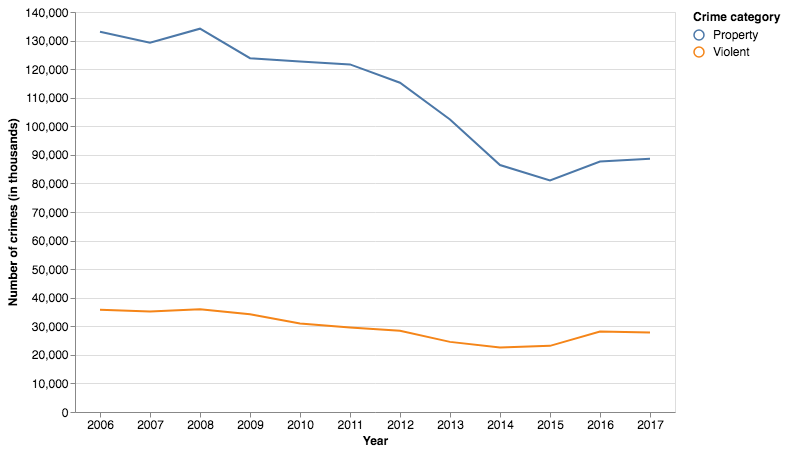

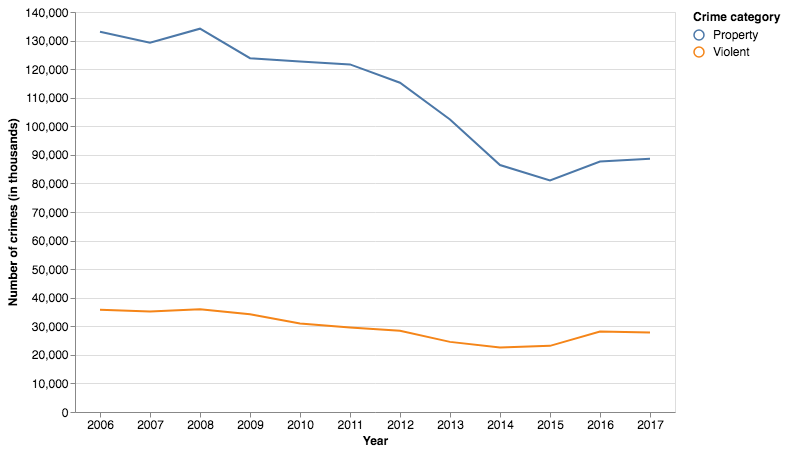

In [20]:
yearly_violent_trend = format_chart(alt.Chart(yearly_crime_counts).mark_line().encode(
    alt.X('Date:O', axis=alt.Axis(title='Year', labelAngle=0)),
    alt.Y('count:Q', axis=alt.Axis(title='Number of crimes (in thousands)')),
    alt.Color('violent:N',
              legend=alt.Legend(title='Crime category'))))
yearly_violent_trend

In [21]:
save_to_jekyll(yearly_violent_trend, 'yearly_violent_trend')

## Table 1
![table_1](../../reports/figures/mcmillen_tab_1.png)

In [22]:
table_1 = schools.groupby('school_year')['treated'].sum().diff().rename(
    'schools_added').reset_index()
table_1.loc[table_1['school_year'] == 'SY0910', 'schools_added'] = schools.loc[
    schools['school_year'] == 'SY0910', 'treated'].sum()
table_1_routes = routes.groupby('school_year')['treated'].sum().diff().rename(
    'routes_added').reset_index()
table_1_routes.loc[table_1_routes['school_year'] == 'SY0910',
                   'routes_added'] = routes.loc[routes['school_year'] ==
                                                'SY0910', 'treated'].sum()
table_1 = pd.merge(table_1_routes, table_1, how='inner', on='school_year')
table_1 = pd.concat(
    [
        table_1,
        pd.DataFrame.from_dict([{
            'school_year': 'total',
            'routes_added': table_1['routes_added'].sum(),
            'schools_added': table_1['schools_added'].sum()
        }])
    ],
    sort=True,
    ignore_index=True)
table_1 = table_1[['school_year', 'routes_added', 'schools_added']]
table_1

,school_year,routes_added,schools_added
0,SY0910,32.0,35.0
1,SY1011,0.0,0.0
2,SY1112,0.0,0.0
3,SY1213,4.0,4.0
4,SY1314,50.0,53.0
5,SY1415,34.0,41.0
6,SY1516,3.0,3.0
7,total,123.0,136.0


## Table 2
![table_2](../../reports/figures/mcmillen_tab_2.png)

## Figure 3

>*"Given the phased way the program was implemented, we normalize to a common start and show the averages for the five pre-program years and for three post-program years. Figure 3a and 3b show that the program was indeed implemented in areas with higher crime incidents but there are no obvious differences in trends before the program implementation. Furthermore, control cells show no significant differences in levels or trends. What is more, after the implementation in the program there’s a drop in the average number of crimes when compared to control areas."* - McMillen et al. (2017), p. 10

Assumption: For figure, drop all blocks which switch status.

![Figure 3](../../reports/figures/mcmillen_fig_3.png)

In [23]:
def make_crime_block_chart(count_col):
    implementation_info = pd.DataFrame([{'implement_year': -0.5}])

    base = alt.Chart().mark_line(clip=True).encode(
        alt.X(
            'run_var:Q',
            axis=alt.Axis(
                title='School years before/after implementation of SP program',
                values=list(range(-5, 3)),
                format='.1'),
            scale=alt.Scale(domain=[-5, 3])),
        alt.Y(
            f'{count_col}',
            axis=alt.Axis(title='Crime count per school year')),
        alt.Color(
            'block_status:N',
            title='Block status',
            sort=[
                'Treated', 'One over', 'Two over',
                'Three over'
            ]))

    
    implementation_rule = alt.Chart(implementation_info).mark_rule().encode(
        x='implement_year:Q')

    implementation_text = alt.Chart(implementation_info).mark_text(
        angle=270, dy=-5, dx=-100).encode(
            alt.X('implement_year:Q'), text=alt.value('Implementation'))

    return alt.layer(
        base.transform_filter('datum.run_var < 0'),
        base.transform_filter('datum.run_var >= 0').encode(
            alt.Color(
                'block_status:N',
                sort=[
                    'Treated', 'One over', 'Two over',
                    'Three over'
                ],
                legend=None)),
        implementation_rule,
        implementation_text,
        data=blocks_fig_3[[
            'run_var',
            count_col,
            'block_status',
        ]],
        # Makes legends independent of one another (needed for sorting to work)
        resolve=alt.Resolve(
            scale=alt.LegendResolveMap(color=alt.ResolveMode('independent'))))


out_violent_crimes = widgets.Output()
out_property_crimes = widgets.Output()

tab = widgets.Tab()
tab.children = [out_violent_crimes, out_property_crimes]
tab.set_title(0, 'Violent crimes')
tab.set_title(1, 'Property crimes')

fig3_violent = format_chart(make_crime_block_chart('violent_count'))
fig3_property = format_chart(make_crime_block_chart('property_count'))

with out_violent_crimes:
    fig3_violent.display()

with out_property_crimes:
    fig3_property.display()

tab

Crime levels are way higher in replication figure. This is certainly at least in part explainable by the different unit of measurement. For this figure they used artificially constructed cells of 1/8th mile on 1/8th mile squares. The census blocks I used have on average a higher area.

Save for use on website

In [24]:
save_to_jekyll(fig3_violent, 'did_figure_violent')
save_to_jekyll(fig3_property, 'did_figure_property')

# Replication of main results

## Table 10 (column 3 and 7)
![table_10](../../reports/figures/mcmillen_tab_10.png)

### Empirical Strategy
$$
crimes_{it} = \beta \textit{ treated_block}_{it} + \gamma_1 \textit{ one_block_over}_{it} + \gamma_2 \textit{ two_block_over}_{it} + \delta_i + \lambda_t + e_{it}
$$

* $crimes_{it}$: either the is the monthly violent or the property crime count at school times
* $treated_block_{it}$ is an indicator variable taking one for blocks in the months that are guarded by Safe Passage personnel
* $one\_block\_over_{it}$, $two\_block\_over_{it}$: indicators for the months after the Safe Passage was enacted if the blocks are one or two blocks over.

Fixed effects:

* $\delta_i$: cell fixed effects
* $\lambda_t$: time fixed effects

Model:

* Poisson regression
    * "The interpretation of a difference-in-difference coefficient from a Poisson regression is $\exp(9) − 1$. However, note that for small enough $\beta$, the approximation $\exp(9) − 1 \approx \beta$ is valid."
    
Period of analysis:

* January 2006 - August 2016

Standard errors clustered by:

* Blocks (they cluster at routes level)

Assumptions:
* If a block is not treated yet it can serve as a control

### Estimation
The estimation is done using the R package [glmmML](https://cran.r-project.org/web/packages/glmmML/glmmML.pdf). As it takes quite long to fit the models, they are already supplied in the `../../models/` folder. One with violent crime count as dependent variable, and the other one with property crime counts. If you want to rerun the estimation (might not work if you run this notebook on mybinder.org), set the following parameter to `True`.

In [ ]:
rerun_estimations = False

In [ ]:
if rerun_estimations:
    # Load packages
    tidyverse = importr('tidyverse')
    glmmML = importr('glmmML')

    # Define functions
    robjects.r("""summary_df <- function(model){
      vars <- names(glm_model_violent$coefficients)[1:3]
      coef <- as.vector(model$coefficients[1:3])
      se <- as.vector(model$sd[1:3])
      z <- coef/se
      p <- 1 - pchisq((z)^2, 1)
      n <- glm_model_violent$n
      return(tibble(var = vars, coef = coef, se = se, z = z, p = p, n = n))
    }

    fit_poisson <- function(df, count_var){
      df$count <- df[[count_var]]
      # First drop all blocks with constant crime count
      # as level would be taken out by tract bloc fixed effects anyway
      non_constant <- df %>%
        group_by(tract_bloc) %>%
        summarize(sd_count = sd(count)) %>%
        filter(sd_count > 0)

      df_nc <- df %>%
        filter(tract_bloc %in% non_constant$tract_bloc) %>%
        select(count, treated, one_over, two_over, tract_bloc, time_fe)
      df_nc$tract_bloc <- as.factor(df_nc$tract_bloc)

      # Fit model
      print(paste0("Fit model with ", count_var))
      poisson_model <- glmmboot(count ~ treated + one_over + two_over + factor(time_fe),
                                    family = poisson, data = df_nc, cluster = tract_bloc)
      return(poisson_model)
    }
    """)

    # Load data
    print('Convert Python data to R')
    pandas2ri.activate()
    robjects.globalenv['est_df'] = pandas2ri.py2ri(est_df[[
        'tract_bloc', 'violent_count', 'property_count', 'treated', 'one_over',
        'two_over', 'three_over', 'time_fe'
    ]])
    # Fit poisson model for violent count
    robjects.r('glm_model_violent <- fit_poisson(est_df, "violent_count")')
    robjects.r('saveRDS(glm_model_violent, "../../models/poisson_violent.rds")')
    # Save summary
    robjects.r('summary_violent <- summary_df(glm_model_violent)')
    robjects.r('write_csv(summary_violent, "../../models/summary_poisson_violent.csv")')
    # Fit poisson model for property count
    robjects.r('glm_model_property <- fit_poisson(est_df, "property_count")')
    robjects.r('saveRDS(glm_model_property, "../../models/poisson_property.rds")')
    # Save summary
    robjects.r('summary_property <- summary_df(glm_model_property)')
    robjects.r('write_csv(summary_property, "../../models/summary_poisson_property.csv")')

# Results

In [25]:
results_violent = pd.read_csv('../../models/summary_poisson_violent.csv')
results_violent

,var,coef,se,z,p,n
0,treated,-0.133810,0.024804,-5.394745,6.862095e-08,1085334
1,one_over,0.009624,0.024244,0.396950,6.914045e-01,1085334
2,two_over,-0.004373,0.024365,-0.179467,8.575707e-01,1085334


In [26]:
results_property = pd.read_csv('../../models/summary_poisson_property.csv')
results_property

,var,coef,se,z,p,n
0,treated,-0.004190,0.013136,-0.318989,0.749735,1085334
1,one_over,0.011522,0.012533,0.919355,0.357910,1085334
2,two_over,0.021531,0.012167,1.769625,0.076790,1085334
